In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from grad_sliding import GradSliding

### 1. Model
Linear layer without bias: $g(x) = Ax$, where $A \in \mathbb{R}^{m \times n}$ is a feature matrix, $x \in \mathbb{R}^n$ is a vector of model's parameters.

### 2. RMSE
\begin{equation*}
    h(x) = \sqrt{\frac{1}{m} \| g(x) - b \|^2} = \frac{1}{\sqrt{m}} \| Ax - b \|,
\end{equation*}
where $b$ is target vector. Let us prove that $h(x)$ is Lipschitz continuous:
\begin{equation*}
    |h(x) - h(y)| = \frac{1}{\sqrt{m}} \bigl\lvert \| Ax - b \| - \| Ay - b \| \bigr\rvert \leq \frac{1}{\sqrt{m}} \| (Ax - b) - (Ay - b) \| = \frac{1}{\sqrt{m}} \| A(x - y) \| \leq \frac{\| A \|}{\sqrt{m}} \| x - y \|.
\end{equation*}
Lipschitz constant is $M_h = \frac{\| A \|}{\sqrt{m}}$. There exist the following theorem:
If convex function $h$ is Lipschitz continuous with parameter $M_h$, then for $M = 2M_h$ the following condition holds:
\begin{equation*}
    h(x) \leq h(y)+\left\langle h^{\prime}(y), x-y\right\rangle+M\|x-y\|\quad \forall x, y
\end{equation*}
In our case, $M = \frac{2}{\sqrt{m}} \| A \|$.

### 3. $L_2$ regularization
\begin{equation*}
    f(x) = \frac{\lambda}{n} \| x \|^2,
\end{equation*}
where $\lambda > 0$ is regularization coefficient. Let us show that $f(x)$ has Lipschitz continuous gradient:
\begin{equation*}
    \nabla f(x) = \frac{2 \lambda}{n} x,\quad \| \nabla f(x) - \nabla f(y) \| = \frac{2 \lambda}{n} \| x - y \|.
\end{equation*}
Thus, $f$ has Lipschitz continuous gradient with parameter $L = \frac{2 \lambda}{n}$.

### 4. Optimization problem
\begin{equation*}
    \min_{x \in \mathbb{R}^n} \left\{ h(x) + f(x) = \frac{1}{\sqrt{m}} \| Ax - b \| + \frac{\lambda}{n} \| x \|^2 \right\}
\end{equation*}
Let us bound squared norm of solution. For $x$ to be at least as good as $0$, the following condition should hold:
\begin{equation*}
    \frac{1}{\sqrt{m}} \| b \| \geq \frac{\lambda}{n} \| x \|^2 \iff \| x \|^2 \leq \frac{n}{\lambda \sqrt{m}} \| b \| =: R^2
\end{equation*}
Now we can reformulate the problem as follows:
\begin{equation*}
    \min_{x \in X} \left\{ h(x) + f(x) \right\},\quad X:= \{ x \in \mathbb{R}^n \bigm| \| x \| \leq R \}
\end{equation*}

### 5. Bregman's distance
Euclidean setup: $V(x, y) = \frac{1}{2} \| x - y \|^2$. Let us find such $D_X^2$ that $V(x, y) \leq D_X^2\ \forall x, y \in X$.
\begin{equation*}
    \frac{1}{2} \| x - y \|^2 \leq \frac{1}{2} \| 2 x_{\text{max}} \|^2 = 2 R^2 = \frac{2n}{\lambda \sqrt{m}} \| b \| =: D_X^2.
\end{equation*}
One of the parameters of gradient sliding is $\tilde{D} := \frac{81}{16} D_X^2 = \frac{81 n}{8 \lambda \sqrt{m}} \| b \|$ (see page 497 of Lan's book, Corollary 8.2).

In [11]:
# Generate data and compute parameters L, M, D_tilde.
m = 100
n = 10
noise_std = 0.01
reg_coef = 1.

np.random.seed(0)
A = np.random.rand(m, n)
np.random.seed(0)
x_true = np.random.rand(n)
np.random.seed(0)
b = A @ x_true + noise_std * np.random.rand(m)

M = 2 * np.linalg.norm(A, ord=2) / np.sqrt(m)
L = 2 * reg_coef / n
D_tilde = 81 * n * np.linalg.norm(b, ord=2) / (8 * reg_coef * np.sqrt(m))
print(f"Algorithm parameters:\nL={L:.2f}, M={M:.2f}, D_tilde={D_tilde:.2f}")

X_train = torch.tensor(A, dtype=torch.float)
y_train = torch.tensor(b.reshape(-1, 1), dtype=torch.float)

Algorithm parameters:
L=0.20, M=3.21, D_tilde=317.02


In [5]:
def train_sliding(opt, model, n_iter):
    """Train `model` via gradient sliding optimizer `opt`.
    
    :param n_iter: number of iterations (gradient evaluations).
    :return: list of losses calculated at each iteration of main loop
        and list of step numbers for each loss value.
    """
    steps = []
    losses = []
    mse = nn.MSELoss()
    for i in range(n_iter):
        y_pred = model(X_train)
        if opt.mode == 'main':
            # Regularization term.
            reg = 0
            for W in model.parameters():
                reg = reg + W.norm(2)**2
            loss = reg_coef * reg / n
        else:
            # RMSE term.
            loss = torch.sqrt(mse(y_pred, y_train))
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # Calculate full loss.
        if i == 0 or opt.mode == 'main':
            opt.to_eval()
            with torch.no_grad():
                y_pred = model(X_train)
                rmse = torch.sqrt(mse(y_pred, y_train))
                reg = 0
                for W in model.parameters():
                    reg = reg + W.norm(2)**2
                loss_sum = rmse + reg_coef * reg / n
                losses.append(loss_sum.item())
                steps.append(opt.steps)
            opt.to_train()
    return losses, steps

def train_model(opt, model, n_iter):
    """Train `model` via optimizer `opt`.
    
    :param n_iter: number of iterations.
    :return: list of losses calculated at each iteration.
    """
    losses = []
    mse = nn.MSELoss()
    for i in range(n_iter):
        y_pred = model(X_train)
        
        # Regularization term.
        reg = 0
        for W in model.parameters():
            reg = reg + W.norm(2)**2
        
        rmse = torch.sqrt(mse(y_pred, y_train))
        loss = rmse + reg_coef * reg / n
        losses.append(loss.detach().item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    return losses

def get_linear():
    return nn.Linear(10, 1, bias=False)

def get_mlp():
    model = nn.Sequential(
                nn.Linear(10, 10),
                nn.ReLU(),
                nn.Linear(10, 5),
                nn.ReLU(),
                nn.Linear(5, 1)
            )
    return model

def experiment(n_attempts, n_evals, L, M, D_tilde, sgd_lr, test_sliding, get_model):
    """Train linear model via gradient sliding and SGD.
    
    :param n_attempts: number of experiments to repeat.
    :param n_evals: number of gradient evaluations during each attempt.
    :return: if `test_sliding` is `True`, return array of average losses
        at each iteration of gradient sliding's main loop, list of
        corresponding step numbers and array of average losses at each
        iteration of SGD. If `test_sliding` is `False`, return array
        of average losses at each iteration of SGD.
    """
    losses_sliding = []
    losses_sgd = []

    mse = nn.MSELoss()
    for i in range(n_attempts):
        if test_sliding:
            model1 = nn.Linear(10, 1, bias=False)
            sliding = GradSliding(model1.parameters(), L, M, D_tilde)
            loss_sl, step_sl = train_sliding(sliding, model1, n_evals)
            losses_sliding.append(loss_sl)

        model2 = nn.Linear(10, 1, bias=False)
        sgd = torch.optim.SGD(model2.parameters(), lr=sgd_lr)
        # In SGD, gradients of both RMSE and regularization term are evaluated
        # at each iteration, hence division by two.
        loss_sgd = train_model(sgd, model2, n_evals // 2)
        losses_sgd.append(loss_sgd)
    
    avg_loss_sgd = np.stack(losses_sgd).mean(axis=0)
    if test_sliding:
        avg_loss_sl = np.stack(losses_sliding).mean(axis=0)
        return avg_loss_sl, step_sl, avg_loss_sgd
    
    return avg_loss_sgd

def plot_convergence(sliding_data, sgd_data):
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12, 6))
    
    step_sl, loss_sl = sliding_data
    plt.plot(step_sl, loss_sl, label="Gradient Sliding")
    
    for step_sgd, loss_sgd, lr in sgd_data:
        plt.plot(step_sgd, loss_sgd, label=f"SGD, lr={lr}")
    
    plt.xlabel("# of gradient evaluations")
    plt.ylabel(r"$f(x) + h(x)$")
    plt.legend()
    plt.show()

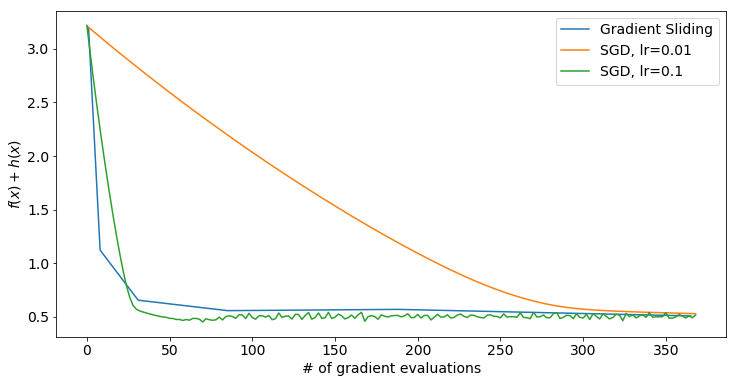

In [19]:
n_attempts = 10
n_evals = 370
lr1 = 0.01
lr2 = 0.1

loss_sl, step_sl, loss_sgd1 = experiment(
    n_attempts, n_evals, L, M, D_tilde, lr1, True, get_linear)
loss_sgd2 = experiment(
    n_attempts, n_evals, L, M, D_tilde, lr2, False, get_linear)

sliding_data = (step_sl, loss_sl)
step_sgd = list(range(0, n_evals, 2))
sgd_data = [(step_sgd, loss_sgd1, lr1), (step_sgd, loss_sgd2, lr2)]

plot_convergence(sliding_data, sgd_data)

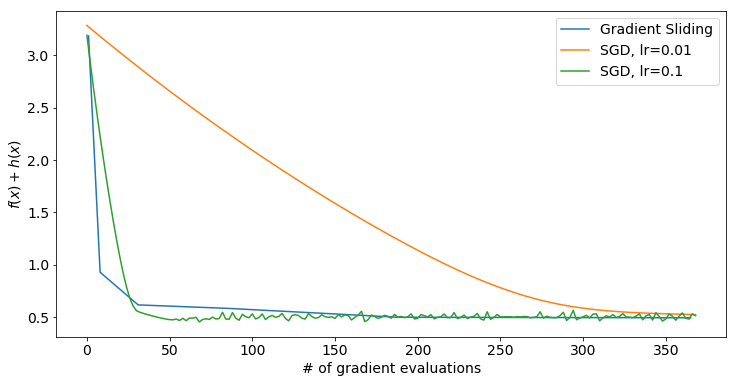

In [23]:
L_ = 1.5 * L
M_ = 1.5 * M
loss_sl, step_sl, loss_sgd1 = experiment(
    n_attempts, n_evals, L_, M_, D_tilde, lr1, True, get_mlp)
loss_sgd2 = experiment(
    n_attempts, n_evals, L_, M_, D_tilde, lr2, False, get_mlp)

sliding_data = (step_sl, loss_sl)
step_sgd = list(range(0, n_evals, 2))
sgd_data = [(step_sgd, loss_sgd1, lr1), (step_sgd, loss_sgd2, lr2)]

plot_convergence(sliding_data, sgd_data)